# Intro

OpenAI's CLIP (Contrastive Language-Image Pretraining) model is a machine learning model designed to understand and generate meaningful representations of images and text. It is trained on a large dataset of images and their associated textual descriptions, learning to associate images with their corresponding text.
The key innovation in CLIP is its use of contrastive learning, which involves training the model to recognize the correct pairing of an image and its description among a set of incorrect pairings. This approach enables the model to learn a wide range of visual concepts and their textual representations, making it capable of performing various tasks, such as image classification, object detection, and zero-shot learning.
CLIP's ability to understand both images and text allows it to be used in a variety of applications, including image search, content moderation, and generating image captions. Its versatility and performance have made it a popular choice for researchers and developers working on computer vision and natural language processing tasks.



# Imports

In [1]:
'''
    name :mahyar jahaninasab
    '''

'\n    name :mahyar jahaninasab\n    '

In [7]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gpaj26qv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gpaj26qv
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=7c28cbe7f7f8edf68b6b45744d826898cf62107b8fc09fa4df2e8d469aaae235
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1hz5ycb/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [8]:
import clip
import torch
import requests
import numpy as np
import torchvision
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

# Data

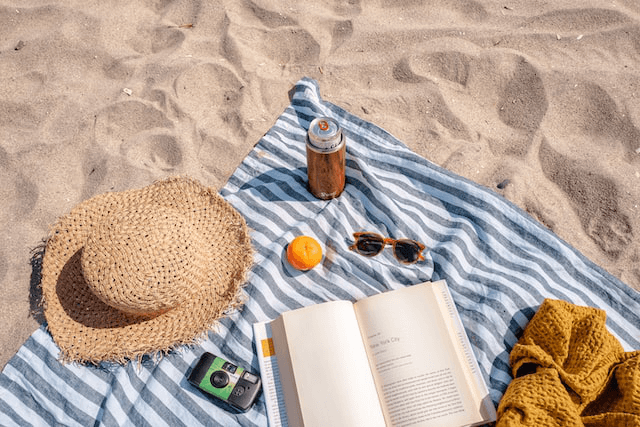

In [3]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")
img

# Extracting candidate regions

For this part use the RegionProposalNetwork in a pretrained faster rcnn to extract some candidate regions of different objects. Then visualize all the bounding boxes. You should get an image like this:

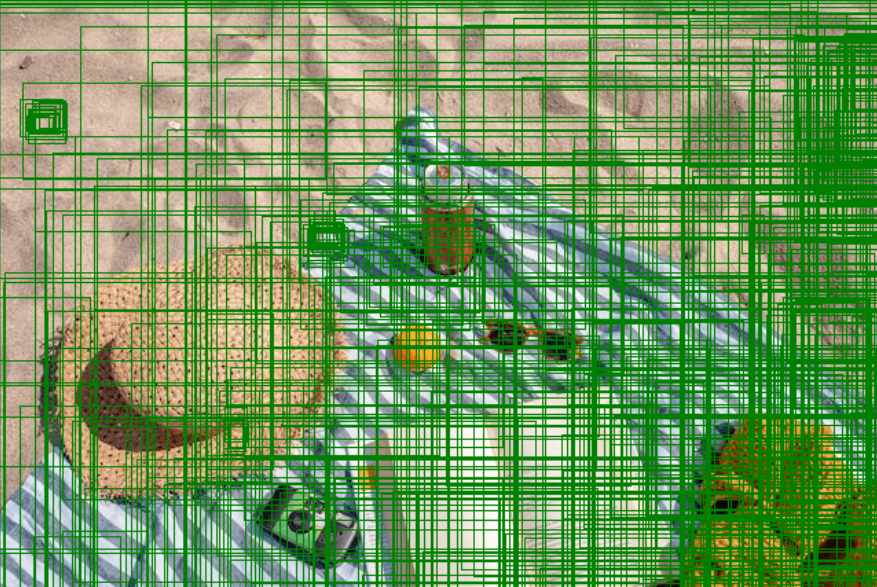

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 107MB/s]


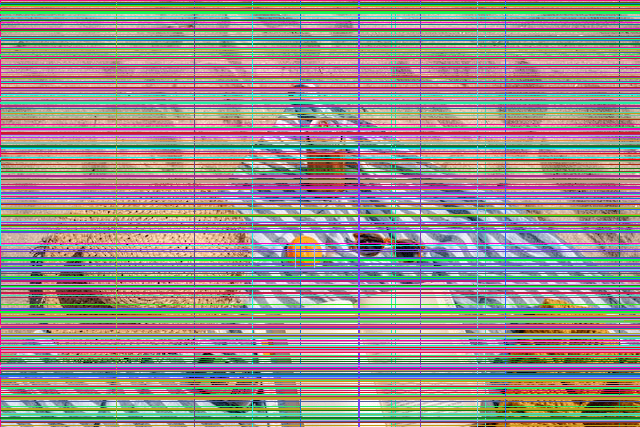

In [4]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")

faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
faster_rcnn.eval()

# =========================== BEGIN ===========================
tensor_img = transforms.functional.pil_to_tensor(img)
tensor_img = tensor_img.to(torch.float32)
outputs = []
hook = faster_rcnn.rpn.register_forward_hook(lambda self, input, output: outputs.append(output))
res = faster_rcnn([tensor_img])
hook.remove()
tensor_img = transforms.functional.pil_to_tensor(img)
boxes = outputs[0][0][0].clone()
# boxes[:,2] = boxes[:,0] - boxes[:,2]
# boxes[:,3] = boxes[:,1] - boxes[:,3]
img_with_box = draw_bounding_boxes(tensor_img,boxes)
transform = transforms.ToPILImage()
image = transform(img_with_box)
image.show()
# =========================== END ===========================

# Object Detection

Now extract the CLIP representation of candidate regions and query text. In order to get better results you need to use an ensemble of prompts for your query. For each query write multiple similar prompts like the given example. Average the embedding of all prompts to get a representation of your query and then compute the cosine similarity between the query and region candidates and return the most likely. Do this for all the queries specified below and save the results in the notebook.

most_probable_candidate_for_finding_fluffy_cat_in_this_img= 0.2356
other_objects


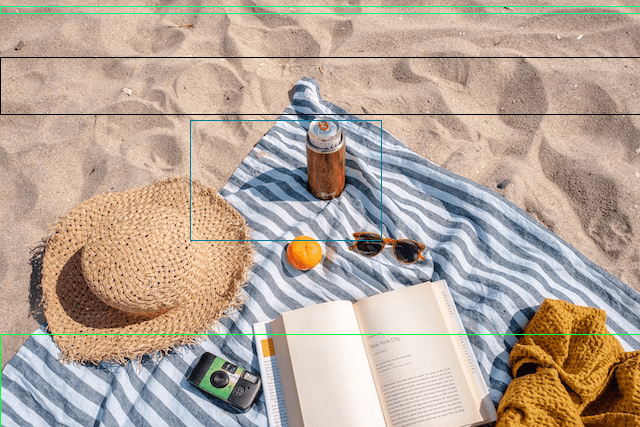

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

query = [
    'a hat',
    'a photo of a hat',
    'a picture of a brown hat']

# query = 'a camera'
# query = 'a book'
# query = 'a fruit'
# query = 'sunglasses'
# query = 'a drink'

# =========================== BEGIN ===========================
query_hat = [
    'a hat',
    'a photo of a hat',
    'a picture of a brown hat']

query_cam = ['a camera',
             'a photo of a  camera',
             'a picture of an old camera']

query_book = ['a book',
              'an open book',
              'a picture of a book on a blanket']

query_fruit = ['a fruit',
               'an orange fruit',
               'a photo of a fruit']

query_sunglass = ['sunglasses',
                  'a picture of a black sunglasses',
                  'a photo of sunglasses']

query_drink = ['a drink',
              'a photo of a drink',
              'a picture of a drink']

list_of_querry = [query_hat,query_cam,query_book,query_fruit,query_sunglass,query_drink]




boxes = outputs[0][0][0].clone()
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

region_embeddings = []
for box in boxes:
    image = preprocess(img.crop(box.cpu().numpy())).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(image)
        region_embeddings.append(image_embedding)

region_embeddings = torch.stack(region_embeddings)

query_embeddings = []
most_likely_region = []
for prompt in list_of_querry:
  text = clip.tokenize(prompt).to(device)
  with torch.no_grad():
    text_embedding = model.encode_text(text)
    embeded = torch.mean(text_embedding,dim=0)
    query_embeddings.append(embeded)

  similarities = torch.nn.functional.cosine_similarity(embeded, region_embeddings.view(555,512))
  most_likely_idx = np.argmax(similarities.cpu().numpy())
  most_likely_region.append(boxes[most_likely_idx])

text_fluffy = clip.tokenize("a fluffy cat").to(device)
text_fluffy_embed = model.encode_text(text_fluffy)
similarities_fluffy = torch.nn.functional.cosine_similarity(text_fluffy_embed, region_embeddings.view(555,512))
print('most_probable_candidate_for_finding_fluffy_cat_in_this_img=',max(similarities_fluffy.detach().cpu().numpy()) )

print('other_objects')
tensor_img = transforms.functional.pil_to_tensor(img)
img_with_box = draw_bounding_boxes(tensor_img,torch.stack(most_likely_region))
transform = transforms.ToPILImage()
image = transform(img_with_box)
image.show()

# =========================== END ===========================